# Spatial and temporal completeness and uncertainties of carbon dioxide satellite observations for quantifying atmospheric greenhouse gas variability

Production date: 31-03-2025

Produced by: CNR

## 🌍 Use case: Using satellite observations for quantifying spatial and temporal variability in carbon dioxide concentrations

## ❓ Quality assessment question
* **Are the XCO$_2$ Level 3 data suitable for identifying regions characterized by high XCO$_2$ values?**
* **What are the uncertainties related to the XCO$_2$ satellite observations?**

Carbon dioxide (CO$_2$) is the most important anthropogenic greenhouse gas, accounting for nearly 64% of the total radiative forcing by long-lived greenhouse gases [[1]](https://library.wmo.int/viewer/68532/?offset=#page=4&viewer=picture&o=bookmarks&n=0&q=). The concentration of CO$_2$ in the atmosphere in 2023 was 419.3$\,\pm\,$0.1 ppm [[2]](https://essd.copernicus.org/articles/17/965/2025/). Monitoring the long-term CO$_2$ variability is crucial for understanding the global carbon sources and sinks, improving our knowledge of the carbon cycle, supporting the development of effective climate policies, and providing more reliable projections for future climate change.

In this assessment, we analyze the spatial variability of atmospheric column-averaged mixing ratios of CO$_2$ (XCO$_2$) over different regions using the Level 3 XCO$_2$ gridded data products (Obs4MIPs, version 4.5 [[3]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf)), whose main application is related to the comparison and validation of global climate models (e.g., [[4]](https://doi.org/10.5194/bg-17-6115-2020)). 

In particular, by comparison with an independent study [[5]](https://www.sciencedirect.com/science/article/pii/S0160412023003306), we assess the ability of this dataset to detect global regions characterised by high XCO$_2$, also quantifying the uncertainty provided with the dataset.

The code is included for transparency and to allow users to adapt it to their needs.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The XCO$_2$ satellite observations (Level 3, Obs4MIPs, version 4.5) provide a  consistent global description of the spatial CO$_2$ pattern and can be used to detect areas characterized by elevated CO$_2$ values.
* As data availability and uncertainty are not constant over space and time, users are advised to consider the evolution of their values over the spatial regions and time periods of interest. The highest uncertainty values were found over high latitudes, the Himalayas and the tropical rainforest zone.
* Users must be aware that the 5$^\circ$x5$^\circ$ averaging can introduce a smoothing effect in the spatial XCO$_2$ field with respect to the Level 2 datasets.
* The main use of this data product is for comparison with climate models. Users interested in investigating the CO$_2$ fluxes occurring at the Earth's surface are advised to use products specifically designed for this purpose.
```

## 📋 Methodology

This notebook aims to provide users with information on the availability of XCO$_2$ Level 3 products, both globally and for specific user-defined regions. Additionally, it offers insights into the uncertainties and errors associated with XCO$_2$ measurements and how these variables vary over time.

More specifically, this notebook aims to:
* Produce maps of XCO$_2$ for comparison with external sources, both globally and for specific regions over land [[5]](https://www.sciencedirect.com/science/article/pii/S0160412023003306).
* Generate a global map for the corresponding XCO$_2$ uncertainty ("xco2_stderr").
* Create time series of selected XCO$_2$ variables ("xco2" and "xco2_stderr"), for defined regions. Please note that this analysis can be extended to two additional variables, not shown here ("xco2_stddev" and "xco2_nobs").
  
The analysis and results are organized in the following steps, which are detailed in the sections below:

**[](template:section-1)**
 * Import all relevant packages.
 * Define the temporal and spatial coverage, land mask, and spatial regions for the analysis.
 * Cache needed functions.

**[](template:section-2)**
 * In this section, we define the data request to CDS.

**[](template:section-3)**
 
 This section presents several results for the XCO$_2$ products, i.e.:
 * Annual global maps of the XCO$_2$ anomalies for 2015-2020
 * Annual global maps of the XCO$_2$ uncertainties for 2015-2020
 * A focus of the XCO$_2$ maps over specific regions, and considering a single month (January 2016)
 * Global and regional time series of XCO$_2$ and related uncertainties over the entire data period (2003-2023)

## 📈 Analysis and results

(template:section-1)=
### 1. Choose the data to use and set-up the code

#### Import all relevant packages
In this section, we import all the relevant packages needed for running the notebook.

In [1]:
import math

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

#### Define temporal and spatial coverage, land mask, and spatial regions for the analysis
In this section, we define the parameters to be ingested by the code (that can be customized by the user), i.e.: 
* the temporal period of analysis;
* the activation/deactivation of the land masking;
* the regions of interest.

In [21]:
# Single time to display
time = "2016-01"

# Range for 2015-2020
time_range = slice("2015", "2020")

# Mask
min_land_fraction = 0.5  # Use None to switch off

# Regions
regions = {
    "global": {"lon_slice": slice(-180, 180), "lat_slice": slice(-90, 90)},
    "north_america": {"lon_slice": slice(-160, -60), "lat_slice": slice(10, 90)},
    "europe_africa": {"lon_slice": slice(-20, 80), "lat_slice": slice(-5, 60)},
    "east_asia": {"lon_slice": slice(70, 165), "lat_slice": slice(-15, 80)},
}

#### Cache needed functions
In this section, we cached a list of functions used in the analyses.

* The `convert_units` function rescales XCO$_2$ mole fraction (and related variables, except "xco2_nobs") to parts per million (ppm).

* The `mask_scale_and_regionalise` function extracts the XCO$_2$ data over the selected spatial region. It uses spatial weighting to account for the latitudinal dependence of the grid size in the lon/lat grids used for the reanalysis and for the forecast models. It uses the `convert_units` function for rescaling the values to ppm, and it applies the threshold (if any) on the minimum land fraction.

In [22]:
def convert_units(da):
    if da.name.endswith("_nobs"):
        return da

    with xr.set_options(keep_attrs=True):
        if da.name.startswith("xch4") and da.attrs["units"] != "ppb":
            da = da * 1.0e9
            da.attrs["units"] = "ppb"
        elif da.name.startswith("xco2") and da.attrs["units"] != "ppm":
            da = da * 1.0e6
            da.attrs["units"] = "ppm"
    return da


def mask_scale_and_regionalise(ds, min_land_fraction, lon_slice, lat_slice):
    if min_land_fraction is not None:
        ds = ds.where(ds["land_fraction"] >= min_land_fraction)
    for var, da in ds.data_vars.items():
        if (fill_value := da.attrs.pop("fill_value", None)) is not None:
            da = da.where(da != fill_value.astype(da.dtype))
        ds[var] = convert_units(da)
    return utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)

(template:section-2)=
### 2. Retrieve data (Obs4MIPs)
In this section, we define the data request to CDS (data product Obs4MIPs, Level 3, version 4.5, XCO$_2$) and download the datasets (i.e., the 2015-2020 period, and the whole dataset).

In [23]:
collection_id = "satellite-carbon-dioxide"
request = {
    "processing_level": ["level_3"],
    "variable": "xco2",
    "sensor_and_algorithm": "merged_obs4mips",
    "version": ["4_5"],
}

In [ ]:
# Retrieve the 2015-2020 dataset
datasets = {}
for region, kwargs in regions.items():
    print(f"{region=}")
    ds = download.download_and_transform(
        collection_id,
        request,
        transform_func=mask_scale_and_regionalise,
        transform_func_kwargs={"min_land_fraction": min_land_fraction} | kwargs,
    ).sel(time=time_range)
    for da in ds.data_vars.values():
        if da.attrs.get("units") in ["1", 1]:
            da.attrs.pop("units")
    datasets[region] = ds

# Retrieve the whole dataset, for plotting the time series
datasets_ts = {}
for region, kwargs in regions.items():
    print(f"{region=}")
    ds = download.download_and_transform(
        collection_id,
        request,
        transform_func=mask_scale_and_regionalise,
        transform_func_kwargs={"min_land_fraction": min_land_fraction} | kwargs,
    )
    for da in ds.data_vars.values():
        if da.attrs.get("units") in ["1", 1]:
            da.attrs.pop("units")
    datasets_ts[region] = ds

(template:section-3)=
### 3. Data analysis for the different variables

#### Global maps of XCO$_2$ anomalies
In this section, we present global maps of XCO$_2$ anomalies for the years 2015–2020. The anomalies are calculated by subtracting the annual global average from the global XCO$_2$ concentrations, following the approach in [[5]](https://www.sciencedirect.com/science/article/pii/S0160412023003306). Before the calculations, a land mask was applied. Throughout all the considered years, regions within the 10$^\circ\,$S–40$^\circ\,$N latitude band exhibit positive XCO$_2$ anomalies, consistent with the findings in [[5]](https://www.sciencedirect.com/science/article/pii/S0160412023003306). Some discrepancies between our results and those in [[5]](https://www.sciencedirect.com/science/article/pii/S0160412023003306) may arise from the differing representativeness of Level 3 XCO$_2$ measurements, which, due to their 5$^\circ$x5$^\circ$ averaging, introduce a smoothing effect. Please note that the horizontal coverage of the XCO2_OBS4MIPS dataset (version 4.5) extends approximately from 60$^\circ\,$S to 70$^\circ\,$N [[6]](https://amt.copernicus.org/articles/13/789/2020/).

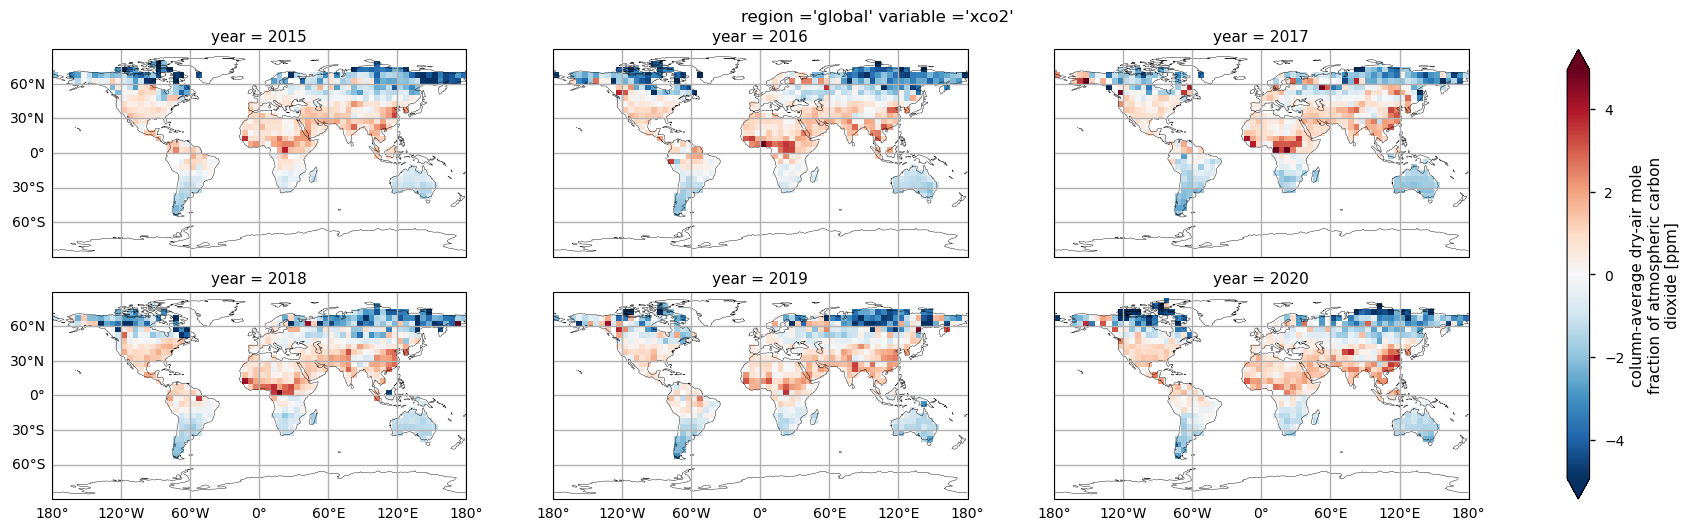

In [33]:
for region in ["global"]:
    ds = datasets[region]
    for variable in ["xco2"]:
        da = diagnostics.annual_weighted_mean(ds[variable])
        da_year = diagnostics.spatial_weighted_mean(da)
        with xr.set_options(keep_attrs=True):
            da = da - da_year
        facet = plot.projected_map(da, col="year", col_wrap=3, figsize=(20, 5), robust=True)
        facet.fig.suptitle(f"{region =} {variable =}", y=1.01)

*The figure shows the multi-year global distribution of XCO$_2$ anomalies (from 2015 to 2020), derived from the XCO2_OBS4MIPS dataset (version 4.5). The title indicates the spatial region and the selected variable.*

#### Global maps of XCO$_2$ uncertainties
In this section, we show the multi-year global maps of the XCO$_2$ reported uncertainties, i.e., the "xco2_stderr" variable. This parameter is defined as the standard error of the average including single sounding noise and potential seasonal and regional biases [[3]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf). The yearly averages are calculated by averaging the monthly values provided by the considered dataset. Throughout all the considered years some features emerge, with higher uncertainties over high latitudes, the Himalayas, and the tropical rainforest zone. This is mainly due to the sparseness in sampling because of frequent cloud cover, as well as large solar zenith angles in high latitudes, which is a challenge for accurate XCO$_2$ retrievals [[6]](https://amt.copernicus.org/articles/13/789/2020/).

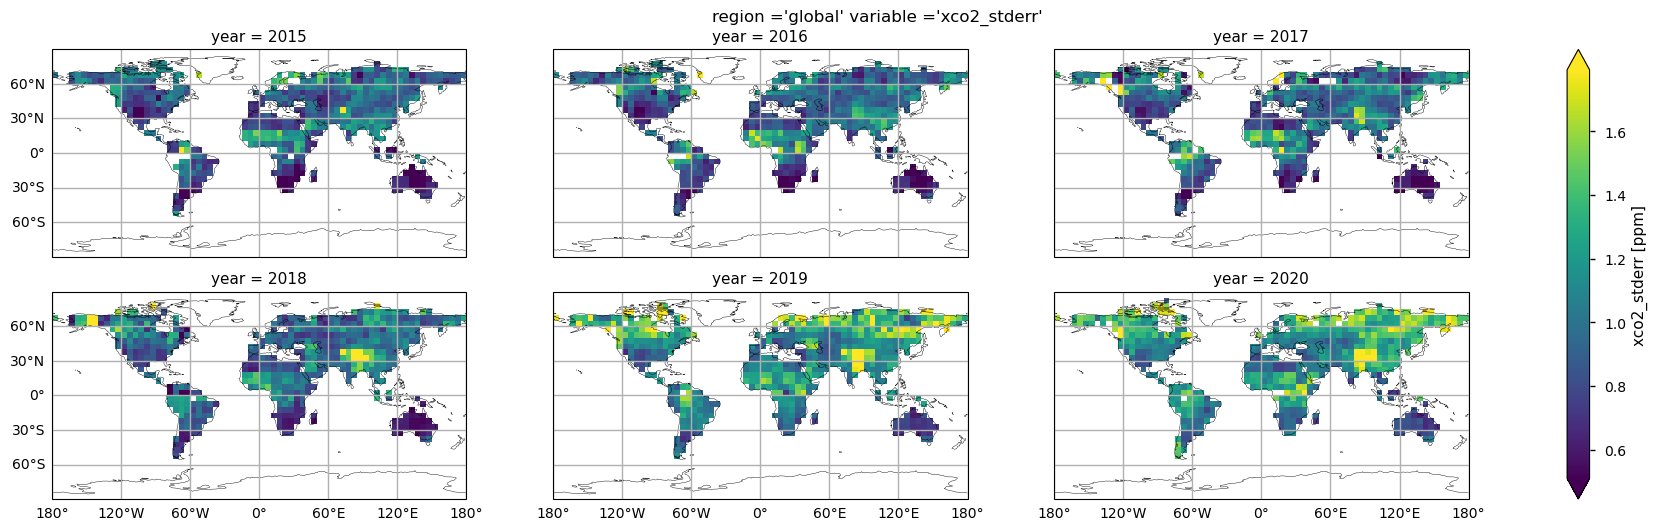

In [26]:
for region in ["global"]:
    ds = datasets[region]
    for variable in ["xco2_stderr"]:
        da = diagnostics.annual_weighted_mean(ds[variable])
        facet = plot.projected_map(da, col="year", col_wrap=3, figsize=(20, 5), robust=True)
        facet.fig.suptitle(f"{region =} {variable =}", y=1.01)

*The figure shows the multi-year global distribution of XCO$_2$ standard error (from 2015 to 2020), derived from the XCO2_OBS4MIPS dataset (version 4.5). The title indicates the spatial region and the selected variable.*

#### Regional maps of XCO$_2$
In this section, we show the maps of the XCO$_2$ values for January 2016, both globally and over specific regions. The selected regions (i.e., North America, Europe/Africa, and East Asia) were chosen according to [[5]](https://www.sciencedirect.com/science/article/pii/S0160412023003306). A direct comparison for January 2015 was not possible, as the Level 3 XCO$_2$ data are missing for that month in the XCO2_OBS4MIPS dataset (version 4.5). Keeping in mind the spatial smoothing of the Level 3 data already mentioned above, the XCO$_2$ patterns are similar and comparable, especially for Europe/Africa and East Asia. However, the Level 3 data cover lesser areas than the product in [[5]](https://www.sciencedirect.com/science/article/pii/S0160412023003306), with missing data especially at latitudes above 50$^\circ\,$N.

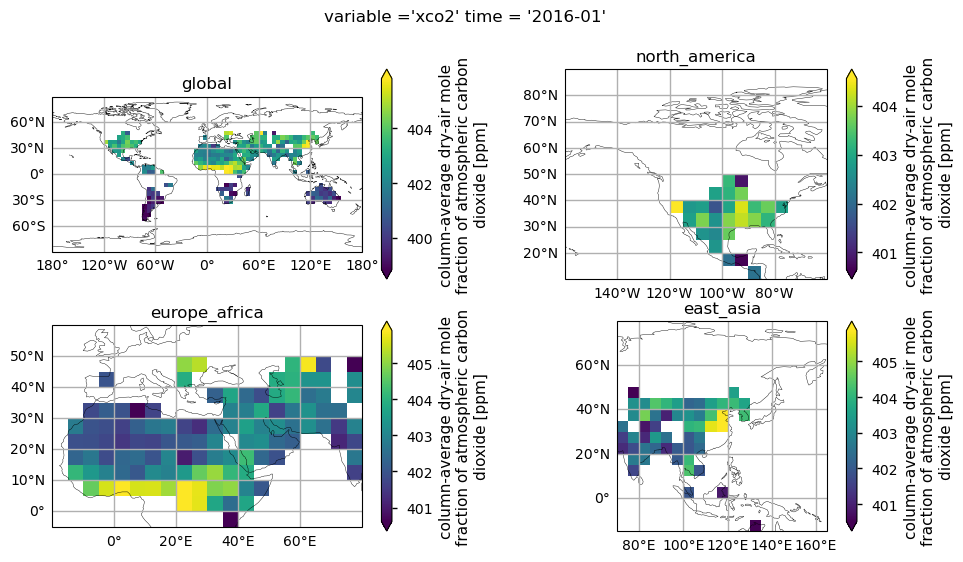

In [34]:
for variable in ["xco2"]:
    fig, axs = plt.subplots(
        2,
        math.ceil(len(regions) / 2),
        subplot_kw={"projection": ccrs.PlateCarree()},
        figsize=(11, 6),
    )
    for ax, (region, ds) in zip(axs.flatten(), datasets.items()):
        da = ds[variable].sel(time=time)
        plot.projected_map(da, ax=ax, show_stats=False, robust=True)
        ax.set_title(region)
    fig.suptitle(f"{variable =} {time = }")
    plt.show()

*The figure shows the spatial distribution of XCO$_2$ values over the globe and selected regions, derived from the XCO2_OBS4MIPS dataset (version 4.5), for January 2016. The title indicates the plotted variable and the selected month.*

#### Time series analysis for the different variables
In this section, we show the time series for two XCO$_2$ variables (i.e., "xco2" and "xco2_stderr"), considering both the entire dataset and specific regions of interest. For each variable, each plot displays the monthly spatial average for each region, along with the corresponding monthly standard deviation.
This analysis would provide the user with:
* the time series of XCO$_2$ values ("xco2") for each region, highlighting the positive trends;
* the regional change over time of the uncertainties associated to the XCO$_2$ values ("xco2_stderr").

In particular, an increase in the uncertainties ("xco2_stderr") is observed after 2009, likely due to the increase in the number of algorithms used to calculate the median XCO$_2$ data [[7]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_ATBD_GHG_D_latest.pdf). A further increase in the uncertainties is observed from 2020 onwards, and this is probably linked to both the increase in the number of algorithms and the change in the minimum number of algorithms required to calculate the median XCO$_2$ [[7]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_ATBD_GHG_D_latest.pdf). In addition, regions with more difficult retrieval conditions (e.g., East Asia) show larger uncertainties due to larger inter-algorithm spreads.

Please note that this analysis can be customized by the user to include two additional variables (not shown here): "xco2_stddev", which represents the standard deviation of the XCO$_2$ L2 observations within each grid box, and "xco2_nobs", which denotes the number of individual XCO$_2$ Level 2 observations used to compute the monthly Level 3 data.

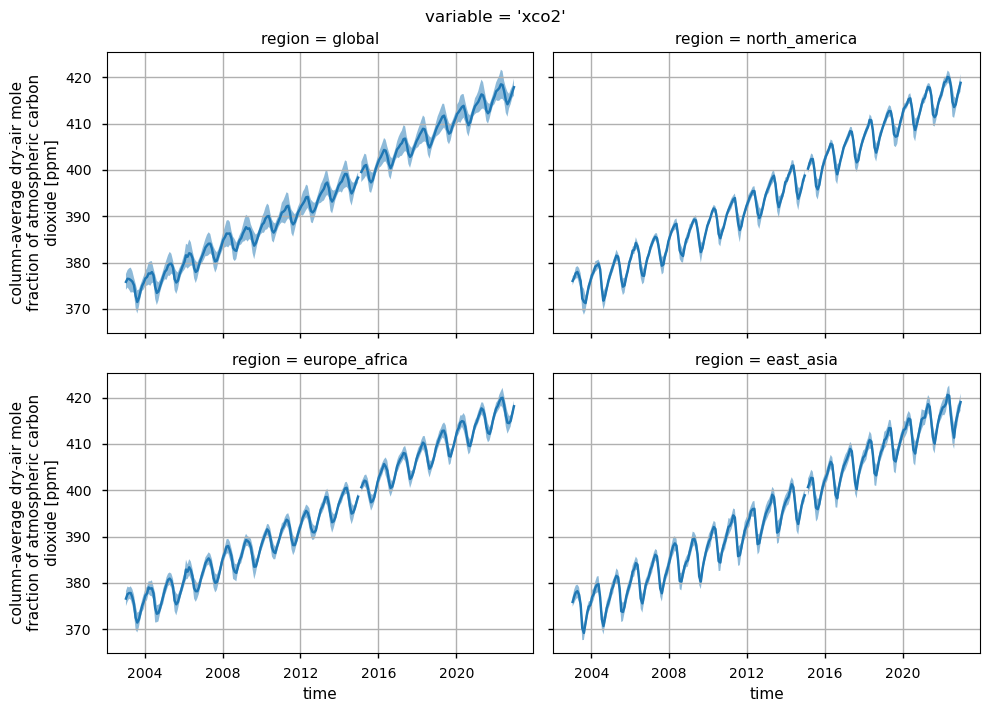

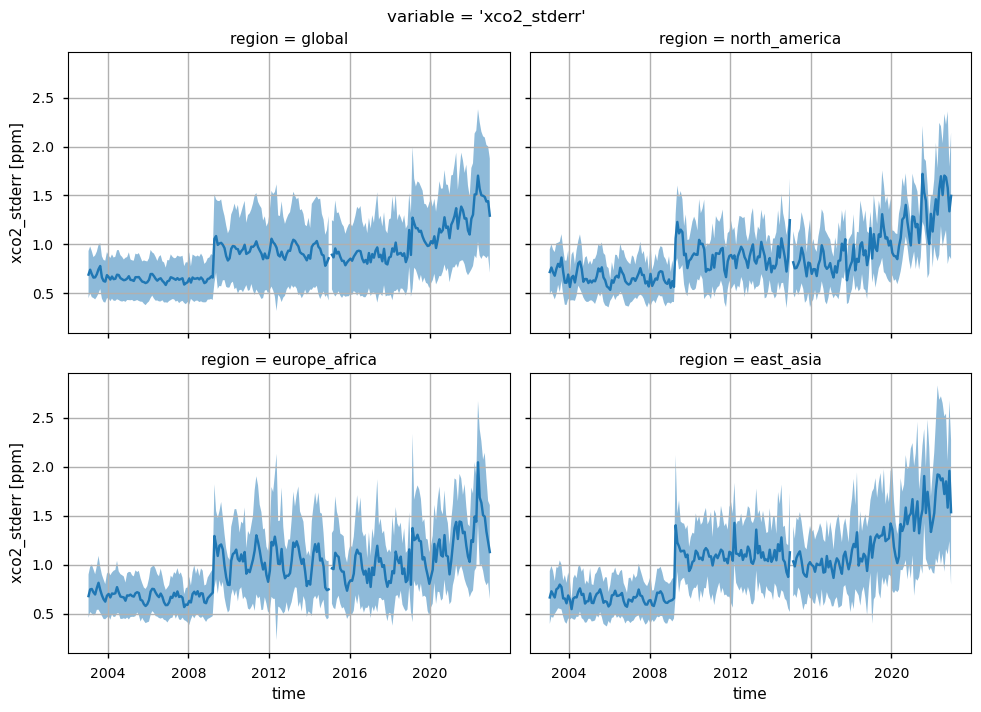

In [40]:
for variable in ["xco2", "xco2_stderr"]:
    means = []
    stds = []
    for region, ds in datasets_ts.items():
        da = ds[variable]
        means.append(diagnostics.spatial_weighted_mean(da).expand_dims(region=[region]))
        stds.append(diagnostics.spatial_weighted_std(da).expand_dims(region=[region]))
    da_mean = xr.concat(means, "region")
    da_std = xr.concat(stds, "region")

    facet = da_mean.plot(col="region", col_wrap=2, figsize=(10, 7))
    for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
        lower = da_mean.sel(sel_dict) - da_std.sel(sel_dict)
        ax.fill_between(
            da["time"],
            lower.where(lower > 0, 0),
            da_mean.sel(sel_dict) + da_std.sel(sel_dict),
            alpha=0.5,
        )
        ax.grid()
    facet.fig.suptitle(f"{variable = }", y=1.01)
    plt.show()

*The figure shows the monthly time series of XCO$_2$ (top panels) and their associated uncertainties (bottom panels) for the entire dataset, including global and regional analyses. The blue lines represent the monthly spatial average, while the shaded areas indicate $\pm$1 standard deviation. The main titles indicate the variable shown, while the subtitles specify the corresponding regions.*

## ℹ️ If you want to know more

### Key resources

The CDS catalogue entries for the data used were:
* Carbon dioxide data from 2002 to present derived from satellite observations: https://cds.climate.copernicus.eu/datasets/satellite-carbon-dioxide?tab=overview

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

Users interested in the investigation of CO$_2$ fluxes can consider to use specifically designed Copernicus resources like [CAMS Methane Hotspot Explorer](https://ads.atmosphere.copernicus.eu/datasets/cams-global-greenhouse-gas-inversion?tab=overview).

### References
[[1]](https://library.wmo.int/viewer/68532/?offset=#page=4&viewer=picture&o=bookmarks&n=0&q=) World Meteorological Organization. (2023). WMO Greenhouse Gas Bulletin, 19, ISSN 2078-0796.

[[2]](https://essd.copernicus.org/articles/17/965/2025/) Friedlingstein, P., O'Sullivan, M., Jones, M. W., Andrew, R. M., Hauck, J., Landschützer, P., Le Quéré, C., Li, H., Luijkx, I. T., Olsen, A., Peters, G. P., Peters, W., Pongratz, J., Schwingshackl, C., Sitch, S., Canadell, J. G., Ciais, P., Jackson, R. B., Alin, S. R., Arneth, A., Arora, V., Bates, N. R., Becker, M., Bellouin, N., Berghoff, C. F., Bittig, H. C., Bopp, L., Cadule, P., Campbell, K., Chamberlain, M. A., Chandra, N., Chevallier, F., Chini, L. P., Colligan, T., Decayeux, J., Djeutchouang, L. M., Dou, X., Duran Rojas, C., Enyo, K., Evans, W., Fay, A. R., Feely, R. A., Ford, D. J., Foster, A., Gasser, T., Gehlen, M., Gkritzalis, T., Grassi, G., Gregor, L., Gruber, N., Gürses, Ö., Harris, I., Hefner, M., Heinke, J., Hurtt, G. C., Iida, Y., Ilyina, T., Jacobson, A. R., Jain, A. K., Jarníková, T., Jersild, A., Jiang, F., Jin, Z., Kato, E., Keeling, R. F., Klein Goldewijk, K., Knauer, J., Korsbakken, J. I., Lan, X., Lauvset, S. K., Lefèvre, N., Liu, Z., Liu, J., Ma, L., Maksyutov, S., Marland, G., Mayot, N., McGuire, P. C., Metzl, N., Monacci, N. M., Morgan, E. J., Nakaoka, S.-I., Neill, C., Niwa, Y., Nützel, T., Olivier, L., Ono, T., Palmer, P. I., Pierrot, D., Qin, Z., Resplandy, L., Roobaert, A., Rosan, T. M., Rödenbeck, C., Schwinger, J., Smallman, T. L., Smith, S. M., Sospedra-Alfonso, R., Steinhoff, T., Sun, Q., Sutton, A. J., Séférian, R., Takao, S., Tatebe, H., Tian, H., Tilbrook, B., Torres, O., Tourigny, E., Tsujino, H., Tubiello, F., van der Werf, G., Wanninkhof, R., Wang, X., Yang, D., Yang, X., Yu, Z., Yuan, W., Yue, X., Zaehle, S., Zeng, N., and Zeng, J. (2025). Global Carbon Budget 2024, Earth System Science Data, 17, 965-1039.

[[3]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf) Buchwitz, M. (2023). Product User Guide and Specification (PUGS) – Main document for Greenhouse Gas (GHG: CO2 & CH4) data set CDR 6 (01.2003-12.2021), C3S project 2021/C3S2_312b_Lot2_DLR/SC1, v6.3.

[[4]](https://doi.org/10.5194/bg-17-6115-2020) Gier, B. K., Buchwitz, M., Reuter, M., Cox, P. M., Friedlingstein, P., and Eyring, V. (2020). Spatially resolved evaluation of Earth system models with satellite column-averaged CO$_2$, Biogeosciences, 17, 6115–6144.

[[5]](https://www.sciencedirect.com/science/article/pii/S0160412023003306) Zhang, L., Li, T., Wu, J., and Yang, H. (2023). Global estimates of gap-free and fine-scale CO$_2$ concentrations during 2014-2020 from satellite and reanalysis data, Environment International, 178, 108057.

[[6]](https://amt.copernicus.org/articles/13/789/2020/) Reuter, M., Buchwitz, M., Schneising, O., Noël, S., Bovensmann, H., Burrows, J. P., Boesch, H., Di Noia, A., Anand, J., Parker, R. J., Somkuti, P., Wu, L., Hasekamp, O. P., Aben, I., Kuze, A., Suto, H., Shiomi, K., Yoshida, Y., Morino, I., Crisp, D., O'Dell, C. W., Notholt, J., Petri, C., Warneke, T., Velazco, V. A., Deutscher, N. M., Griffith, D. W. T., Kivi, R., Pollard, D. F., Hase, F., Sussmann, R., Té, Y. V., Strong, K., Roche, S., Sha, M. K., De Mazière, M., Feist, D. G., Iraci, L. T., Roehl, C. M., Retscher, C., and Schepers, D. (2020). Ensemble-based satellite-derived carbon dioxide and methane column-averaged dry-air mole fraction data sets (2003–2018) for carbon and climate applications, Atmospheric Measurement Techniques, 13, 789–819.

[[7]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_ATBD_GHG_D_latest.pdf) Reuter, M., and Buchwitz, M. (2024). Algorithm Theoretical Basis Document (ATBD) – ANNEX D for products XCO2_EMMA, XCH4_EMMA, XCO2_OBS4MIPS, XCH4_OBS4MIPS (v4.5, CDR7, 2003-2022), C3S project 2021/C3S2_312a_Lot2_DLR/SC1, v7.1b.